# 2023-01-23
## Building Micrograd
https://github.com/karpathy/micrograd

In [203]:
from __future__ import annotations
import math
from typing import Callable, Union, Optional, Tuple, List, Set

import graphviz
import matplotlib.pyplot as plt
import numpy as np

In [79]:
from graphviz import Digraph


def trace(root):
    # builds a set of all nodes and edges in a graph
    nodes, edges = set(), set()

    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)

    build(root)
    return nodes, edges


def draw_dot(root):
    dot = Digraph(format="svg", graph_attr={"rankdir": "LR"})  # LR = left to right

    nodes, edges = trace(root)
    for n in nodes:
        uid = str(id(n))
        # for any value in the graph, create a rectangular ('record') node for it
        dot.node(
            name=uid,
            label="{ %s | data %.4f | grad %.4f}" % (n.label, n.data, n.grad),
            shape="record",
        )
        if n._op:
            # if this value is a result of some operation, create an op node for it
            dot.node(name=uid + n._op, label=n._op)
            # and connect this node to it
            dot.edge(uid + n._op, uid)

    for n1, n2 in edges:
        # connect n1 to the op node of n2
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)

    return dot

In [80]:
def f(x: float) -> float:
    return 3 * x**2 - 4 * x + 5

In [81]:
f(3.0)

20.0

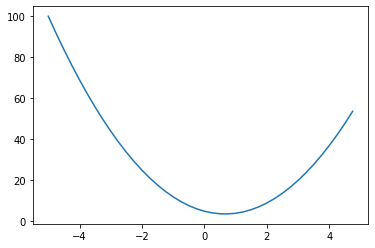

In [82]:
xs = np.arange(-5, 5, 0.25)
ys = f(xs)
plt.plot(xs, ys)

$L = lim_{h \to 0} = \frac{f(x+h) - f(x)}{h}$

In [83]:
x = 3.0
h = 1e-10 # 0.001
print("f(x)", f(x)) 
print("f(x + h)", f(x + h))
print("change", f(x + h) - f(x))
print("Size of slope", (f(x + h) - f(x)) / h)

f(x) 20.0
f(x + h) 20.0000000014
change 1.4000001158365194e-09
Size of slope 14.000001158365194


In [84]:
x = -1
h = 1e-10 # 0.001
print("f(x)", f(x)) 
print("f(x + h)", f(x + h))
print("change", f(x + h) - f(x))
print("Size of slope", (f(x + h) - f(x)) / h)

f(x) 12
f(x + h) 11.999999999
change -1.000000082740371e-09
Size of slope -10.00000082740371


In [85]:
x = -3
h = 1e-10 # 0.001
print("f(x)", f(x)) 
print("f(x + h)", f(x + h))
print("change", f(x + h) - f(x))
print("Size of slope", (f(x + h) - f(x)) / h)

f(x) 44
f(x + h) 43.9999999978
change -2.1999966293151374e-09
Size of slope -21.999966293151374


In [86]:
a = 2.0
b = -3.0
c = 10.0

d = a * b + c

print(d)

4.0


In [87]:
h = 1e-9

a = 2.0
b = -3.0
c = 10.0

d1 = a * b + c
a += h
d2 = a * b + c

print(d1, d2)
print((d2 - d1) / h)

4.0 3.9999999969999998
-3.000000248221113


In [88]:
h = 1e-9

a = 2.0
b = -3.0
c = 10.0

d1 = a * b + c
b += h
d2 = a * b + c

print(d1, d2)
print((d2 - d1) / h)

4.0 4.000000002
2.000000165480742


In [89]:
h = 1e-9

a = 2.0
b = -3.0
c = 10.0

d1 = a * b + c
c += h
d2 = a * b + c

print(d1, d2)
print((d2 - d1) / h)

4.0 4.000000001
1.000000082740371


```
f(a) = a * -3 + 10
f'(a) = -3

((a+h)* b + c - (a*b +c)) / h = (ab + bh + c - ab - c) / h = bh / h = b
```

In [204]:
class Value:
    def __init__(
        self,
        data: float,
        _children: Optional[Tuple[Value]] = None,
        _op: Optional[str] = None,
        _label: Optional[str] = None
    ) -> None:
        self._data = data
        self._prev = set(_children) if _children else set(())
        self._op = _op if _op else ""
        self._backward = lambda: None
        self._label = _label if _label else ""

        self._grad = 0.0

    @property
    def grad(self) -> float:
        return self._grad
    
    @grad.setter
    def grad(self, grad: float) -> None:
        self._grad = grad
    
    @property
    def label(self) -> str:
        return self._label
    
    @label.setter
    def label(self, label: str) -> None:
        self._label = label

    @property
    def data(self) -> float:
        return self._data
    
    @data.setter
    def data(self, data: float) -> None:
        self._data = data

    # ---- PARSING DECORATOR ----

    def _parse_to_value(func: Callable) -> Callable:
        def wrapper(self, value: Union[float, Value]) -> Value:
            parsed_value = value if isinstance(value, Value) else Value(value)
            return func(self, parsed_value)
        return wrapper
    
    # ---- MAGIC METHODS ----

    def __repr__(self) -> str:
        return f"Value(data={self._data},label='{self._label}')"

    # ---- MATH FNS ----
    @_parse_to_value 
    def __add__(self, other: Value) -> Value:
        out = Value(self._data + other.data, (self, other), "+")
        def _backward() -> None:
            self._grad = 1.0 * out.grad
            other._grad = 1.0 * out.grad

        out._backward = _backward
        return out

    @_parse_to_value
    def __mul__(self, other: Value) -> Value:
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self._data * other.data, (self, other), "*")
        def _backward() -> None:
            self._grad = other.data * out.grad
            other._grad = self._data * out.grad

        out._backward = _backward

        return out


    def __radd__(self, other: Value) -> Value:
        return self + other

    def __rmul__(self, other: Value) -> Value:
        return self * other

    def __sub__(self, other: Value) -> Value:
        return self + (-other)

    def __neg__(self) -> Value:
        return self * -1

    # ---- ADDITIONAL OPS ----
    def tanh(self) -> Value:
        x = self._data
        t = (math.exp(2 * x) - 1) / (math.exp(2 * x) + 1)
        out = Value(t, (self, ), "tanh")
        def _backward() -> None:
            self._grad = (1 - t**2) * out.grad

        out._backward = _backward

        return out

    # ---- BACKWARDS COMP ----
    def backward(self):
        topo: List[Value] = []
        visited: Set[Value] = set()

        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)

        build_topo(self)

        self._grad = 1.0
        
        for node in reversed(topo):
            node._backward()

In [174]:
Value(10.0) + Value(2.0)

Value(data=12.0,label='')

In [175]:
Value(10.0) * Value(2.0)

Value(data=20.0,label='')

In [176]:
Value(10.0) * 2.0

Value(data=20.0,label='')

In [177]:
Value(10.0) - Value(2.0)

Value(data=8.0,label='')

In [178]:
5 * Value(2.0)

Value(data=10.0,label='')

In [179]:
res = Value(2.0) + Value(3.0)
print(res._prev, res._op, " = ", res)

{Value(data=3.0,label=''), Value(data=2.0,label='')} +  =  Value(data=5.0,label='')


Value(data=4.0,label='d')


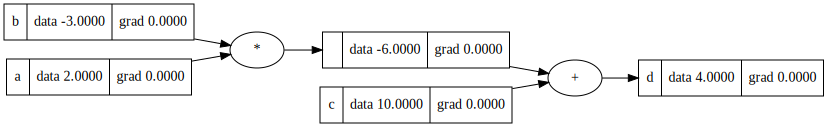

In [180]:
# Graph viz

a = Value(2.0, _label="a")
b = Value(-3.0, _label="b")
c = Value(10.0, _label="c")

d = a * b + c

d.label = "d"
print(d)

draw_dot(d)

In [181]:

# let's say x = 2.0
f1 = Value(3.0) * Value(2.0) * Value(2.0)  - Value(4.0) * Value(2.0) + Value(5.0)
print(f1)
print(f(2))

draw_dot(f1)

Value(data=9.0,label='')


TypeError: 'Value' object is not callable

In [ ]:
a = Value(2.0, _label="a")
b = Value(-3.0, _label="b")
c = Value(10.0, _label="c")

d = a * b + c

d.label = "d"
print(d)

draw_dot(d)

```
dd/da = (f((a + h) * b + c) - f(a * b + c)) / h = b

dd/db = (f((a + h) * b + c) - f(a * b + c)) / h = a

dd/dc = (f((a * b + c + h) - f(a * b + c)) / h = (ab + c + h - ab - c) / h = h / h = 1
```

Value(data=4.0,label='d')


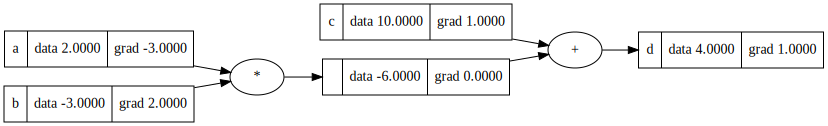

In [ ]:
a = Value(2.0, _label="a")
b = Value(-3.0, _label="b")
c = Value(10.0, _label="c")

d = a * b + c

d.label = "d"

a.grad = -3.0
b.grad = 2.0
c.grad = 1.0

'''
(f(x) + h - f(x)) / h = 1
'''
d.grad = 1.0
print(d)

draw_dot(d)

Value(data=-8.0,label='L')


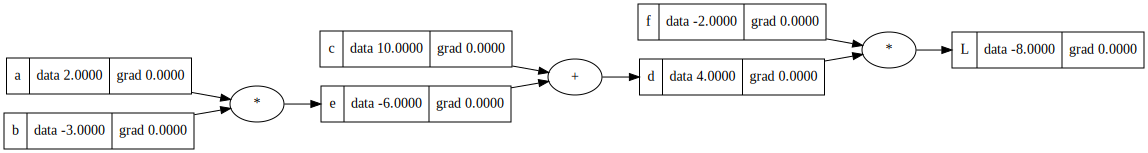

In [ ]:
a = Value(2.0, _label="a")
b = Value(-3.0, _label="b")
c = Value(10, _label="c")
f = Value(-2.0, _label="f")

e = a * b
e.label = "e"

d = e + c
d.label = "d"

L = d * f
L.label = "L"
print(L)
draw_dot(L)

In [ ]:
'''
L = f(f) = fd
f'(f) = (f(x + h) - f(x)) / h = ((f+h) * d - (f * d)) / h = (fd + dh - fd) / h = dh / h = d
'''
L = f * 4

```
d = c + e

dd / dc = 1.0
dd / de = 1.0


dL / dc = (dL / dd) * (dd / dc)

dL / dd = f = -2.0

dL / dc = -2.0 * 1.0
```


```

e = a * b
d = c + e
L = d * f


dL / da = (dL / dd) * (dd / de) * (de / da) = -2.0 * 1.0 * -3.0 = 6.0

dL / dd = f = -2.0
dL / de = 1.0
de / da = b = -3.0

dL / db = (dL / dd) * (dd / de) * (de / db) = -2.0 * 1.0 * 2.0 = -4.0

--- e = a * b ---
de / db = a = 2.0 

``

Value(data=-8.0,label='L')


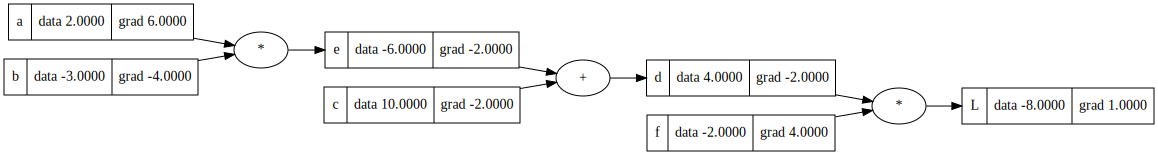

In [ ]:
a = Value(2.0, _label="a")
b = Value(-3.0, _label="b")
c = Value(10, _label="c")
f = Value(-2.0, _label="f")

e = a * b
e.label = "e"

d = e + c
d.label = "d"

L = d * f
L.label = "L"

### GRADS
a.grad = 6.0
b.grad = -4.0
c.grad = -2.0
e.grad = -2.0
d.grad = -2.0
f.grad = 4.0
L.grad = 1.0


print(L)
draw_dot(L)

In [ ]:
a = Value(2.0, _label="a")
b = Value(-3.0, _label="b")
c = Value(10, _label="c")
f = Value(-2.0, _label="f")

e = a * b
e.label = "e"

d = e + c
d.label = "d"

L = d * f
L.label = "L"

### GRADS
a.grad = 6.0
b.grad = -4.0
c.grad = -2.0
e.grad = -2.0
d.grad = -2.0
f.grad = 4.0
L.grad = 1.0

lr = 1e-3

print(L)

a += a.grad * lr
b += b.grad * lr
c += c.grad * lr
c += f.grad * lr

e = a * b
d = e + c
L = d * f

print(L)

Value(data=-8.0,label='L')
Value(data=-7.951951999999999,label='')


In [ ]:
def test_grad() -> None:
    h = 1e-9

    a = Value(2.0, _label="a")
    b = Value(-3.0, _label="b")
    c = Value(10, _label="c")
    f = Value(-2.0, _label="f")

    e = a * b
    e.label = "e"

    d = e + c
    d.label = "d"

    L = d * f
    L.label = "L"
    L1 = L.data

    a = Value(2.0, _label="a")
    b = Value(-3.0, _label="b")
    b += h
    c = Value(10, _label="c")
    f = Value(-2.0, _label="f")

    e = a * b
    e.label = "e"


    d = e + c
    d.label = "d"

    L = d * f
    L.label = "L"
    L2 = L.data

    print(L1, L2)
    print(L2 - L1)
    print((L2 - L1) / h)

test_grad()

-8.0 -8.000000004
-4.000000330961484e-09
-4.000000330961484


![](https://www.allaboutcircuits.com/uploads/articles/how-to-train-a-basic-perceptron-neural-network_rk_aac_image1.jpg)

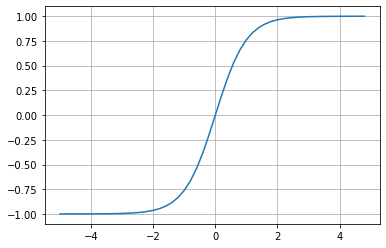

In [ ]:
# (math.exp(2 * x) - 1) / (math.exp(2 * x) + 1)

plt.plot(np.arange(-5, 5, 0.2), np.tanh(np.arange(-5, 5, 0.2)))
plt.grid()

In [ ]:
def tanh_ours(x: float) -> float:
    return (math.exp(2 * x) - 1) / (math.exp(2 * x) + 1)

In [ ]:
# NEURAL NET
# f(x1, x2) = tanh(x1*w1 + x2*w2 + b)

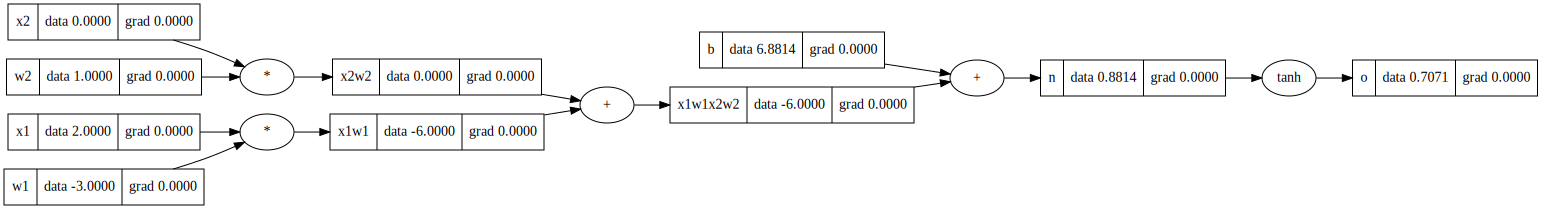

In [ ]:
# inputs x1, x2
x1 = Value(2.0, _label="x1")
x2 = Value(0.0, _label="x2")
# weights w1, w2
w1 = Value(-3.0, _label="w1")
w2 = Value(1.0, _label="w2")
# bias
b = Value(6.8813735870195432, _label="b")
# w1*x1 + w2*x2 + b
x1w1 = x1 * w1
x1w1.label = "x1w1"
x2w2 = x2 * w2
x2w2.label = "x2w2"
x1w1x2w2 = x1w1 + x2w2
x1w1x2w2.label = "x1w1x2w2"
n = x1w1x2w2 + b
n.label = "n"
o = n.tanh()
o.label = "o"

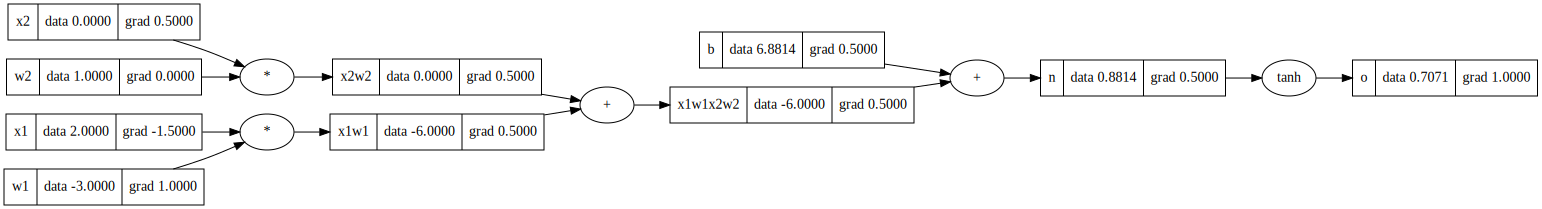

In [ ]:
draw_dot(o)

In [ ]:
# Calculate grads
o.grad = 1.0

'''
o = tanh(n)

do/dn = 1 - tanh(n)**2 = 1 - o**2
'''
n.grad = 0.5

b.grad = 0.5
x1w1x2w2.grad = 0.5

x2w2.grad = 0.5
x1w1.grad = 0.5

x2.grad = x2w2.grad * w2.data
w2.grad = x2w2.grad * x2.data

x1.grad = x1w1.grad * w1.data
w1.grad = x1w1.grad * x1.data


In [ ]:
'''
1) x1w1 = x1 * w1 
2) x2w2 = x2 * w2
3) n = x1w1 + x2w2 + b = (x1 * w1) + (x2 * w2) + b
n/w1 = n/x1w1 * x1w1/w1 = 0.5 * 2.0 = 1.0
'''

'\n1) x1w1 = x1 * w1 \n2) x2w2 = x2 * w2\n3) n = x1w1 + x2w2 + b = (x1 * w1) + (x2 * w2) + b\nn/w1 = n/x1w1 * x1w1/w1 = 0.5 * 2.0 = 1.0\n'

### After auto_grad addition

In [197]:
# inputs x1, x2
x1 = Value(2.0, _label="x1")
x2 = Value(0.0, _label="x2")
# weights w1, w2
w1 = Value(-3.0, _label="w1")
w2 = Value(1.0, _label="w2")
# bias
b = Value(6.8813735870195432, _label="b")
# w1*x1 + w2*x2 + b
x1w1 = x1 * w1
x1w1.label = "x1w1"
x2w2 = x2 * w2
x2w2.label = "x2w2"
x1w1x2w2 = x1w1 + x2w2
x1w1x2w2.label = "x1w1x2w2"
n = x1w1x2w2 + b
n.label = "n"
o = n.tanh()
o.label = "o"

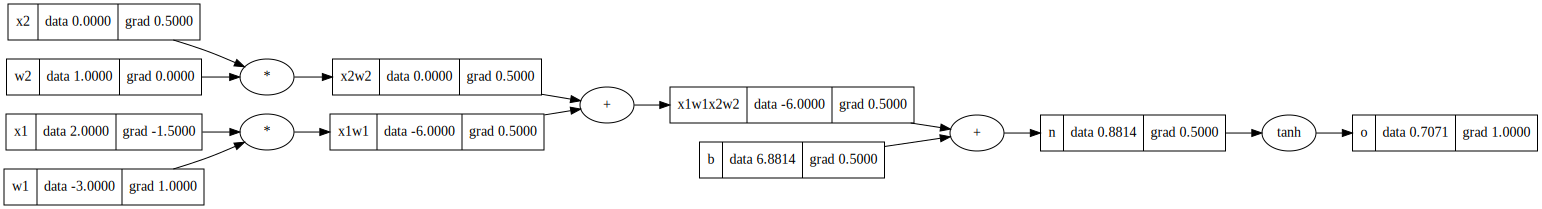

In [190]:
draw_dot(o)

In [189]:
o.grad = 1
o._backward()
n._backward()
x1w1x2w2._backward()
x2w2._backward()
x1w1._backward()

![](https://camo.githubusercontent.com/d40194bc76ed6c57da406962dc711b08d621df197aa4a2509387999427280f98/68747470733a2f2f6d69726f2e6d656469756d2e636f6d2f6d61782f313430302f312a754d675f6f6a4658747332575a536a635a65346f52512e706e67)

In [194]:
topo = []
visited = set()


def build_topo(v):
    if v not in visited:
        visited.add(v)
        for child in v._prev:
            build_topo(child)
        topo.append(v)

build_topo(o)
topo

[Value(data=6.881373587019543,label='b'),
 Value(data=2.0,label='x1'),
 Value(data=-3.0,label='w1'),
 Value(data=-6.0,label='x1w1'),
 Value(data=0.0,label='x2'),
 Value(data=1.0,label='w2'),
 Value(data=0.0,label='x2w2'),
 Value(data=-6.0,label='x1w1x2w2'),
 Value(data=0.8813735870195432,label='n'),
 Value(data=0.7071067811865476,label='o')]

In [196]:
[i for i in reversed(topo)]

[Value(data=0.7071067811865476,label='o'),
 Value(data=0.8813735870195432,label='n'),
 Value(data=-6.0,label='x1w1x2w2'),
 Value(data=0.0,label='x2w2'),
 Value(data=1.0,label='w2'),
 Value(data=0.0,label='x2'),
 Value(data=-6.0,label='x1w1'),
 Value(data=-3.0,label='w1'),
 Value(data=2.0,label='x1'),
 Value(data=6.881373587019543,label='b')]

In [209]:
# inputs x1, x2
x1 = Value(2.0, _label="x1")
x2 = Value(0.0, _label="x2")
# weights w1, w2
w1 = Value(-3.0, _label="w1")
w2 = Value(1.0, _label="w2")
# bias
b = Value(6.8813735870195432, _label="b")
# w1*x1 + w2*x2 + b
x1w1 = x1 * w1
x1w1.label = "x1w1"
x2w2 = x2 * w2
x2w2.label = "x2w2"
x1w1x2w2 = x1w1 + x2w2
x1w1x2w2.label = "x1w1x2w2"
n = x1w1x2w2 + b
n.label = "n"
o = n.tanh()
o.label = "o"

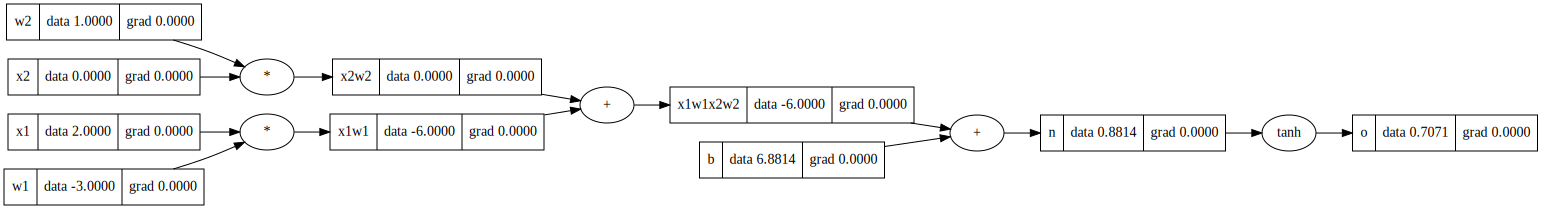

In [210]:
draw_dot(o)

In [213]:
o.backward()

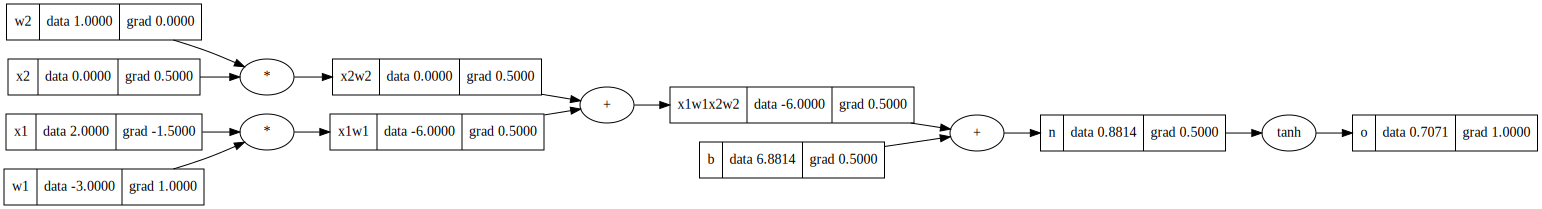

In [214]:
draw_dot(o)